### 作業
請嘗試使用 flip (左右翻轉) 來做 augmentation 以降低人臉關鍵點檢測的 loss

Note: 圖像 flip 之後，groundtruth 的關鍵點也要跟著 flip 哦




### 範例
接下來的程式碼會示範如何定義一個簡單的 CNN model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
%matplotlib inline

In [ ]:
# 使用 colab 環境的同學請執行以下程式碼
# %tensorflow_version 1.x # 確保 colob 中使用的 tensorflow 是 1.x 版本而不是 tensorflow 2
# import tensorflow as tf
# print(tf.__version__)

# import os
# from google.colab import drive 
# drive.mount('/content/gdrive') # 將 google drive 掛載在 colob，
# %cd 'gdrive/My Drive'
# os.system("mkdir cupoy_cv_part4") # 可以自己改路徑
# %cd cupoy_cv_part4 # 可以自己改路徑

In [2]:
# 讀取資料集以及做前處理的函數
def load_data(dirname):
    # 讀取 csv 文件
    data = pd.read_csv(dirname)
    # 過濾有缺失值的 row
    data = data.dropna()

    # 將圖片像素值讀取為 numpy array 的形態
    data['Image'] = data['Image'].apply(lambda img: np.fromstring(img, sep=' ')).values 

    # 單獨把圖像 array 抽取出來
    imgs = np.vstack(data['Image'].values)/255
    # reshape 為 96 x 96
    imgs = imgs.reshape(data.shape[0], 96, 96)
    # 轉換為 float
    imgs = imgs.astype(np.float32)
    
    # 提取坐標的部分
    points = data[data.columns[:-1]].values

    # 轉換為 float
    points = points.astype(np.float32)

    # normalize 坐標值到 [-0.5, 0.5]
    points = points/96 - 0.5
    
    return imgs, points

In [3]:
# 讀取資料
imgs_train, points_train = load_data(dirname = 'D:\\Python\\1st DL\\Day042\\training.csv')
print("圖像資料:", imgs_train.shape, "\n關鍵點資料:", points_train.shape)

圖像資料: (2140, 96, 96) 
關鍵點資料: (2140, 30)


In [4]:
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

Using TensorFlow backend.


In [5]:
# 回傳定義好的 model 的函數
def get_model():
    # 定義人臉關鍵點檢測網路
    model = Sequential()

    # 定義神經網路的輸入
    model.add(Conv2D(filters=16, kernel_size=3, activation='relu', input_shape=(96, 96, 1)))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))

    # 最後輸出 30 維的向量，也就是 15 個關鍵點的值
    model.add(Dense(30))
    return model

In [6]:
model = get_model()
# 配置 loss funtion 和 optimizer
model.compile(loss='mean_squared_error', optimizer='adam')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [7]:
# 印出網路結構
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 94, 94, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 47, 47, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 20, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 128)         73856     
__________

In [8]:
from keras.callbacks import ModelCheckpoint, History
best_weights_path = "D:\\Python\\1st DL\\Day044\\best_weights.h5"
file_path = "D:\\Python\\1st DL\\Day044\\file.json"
weights_path = "D:\\Python\\1st DL\\Day044\\weights.h5"
model_path = "D:\\Python\\1st DL\\Day044\\model.h5"

# model checkpoint 
checkpoint = ModelCheckpoint(best_weights_path, verbose=1, save_best_only=True)
hist = History()

In [56]:
def model_fit(model, file_path, weights_path, model_path, checkpoint):
    if os.path.exists(file_path) :
        print("have model.h5 so load weights")
        with open(file_path, "r") as file:
            hist_model = json.loads(file.read())
        model = load_model(model_path)
    else :
        # training the model
        hist_model = model.fit(imgs_train.reshape(-1, 96, 96, 1), 
                               points_train, 
                               validation_split=0.2, batch_size=64, callbacks=[checkpoint, hist],
                               shuffle=True, epochs=150, verbose=1)
        # save the model weights
        model.save_weights(weights_path)
        # save the model
        model.save(model_path)
        
        # save the file to json
        with open(file_path, "w+") as f:
            json.dump(hist_model.history, f)
        hist_model = hist_model.history
    
    return model, hist_model

have model.h5 so load weights


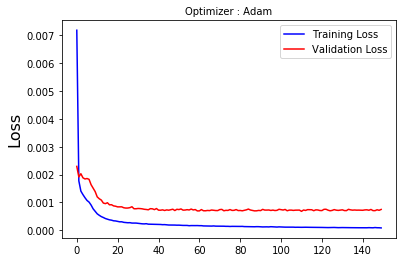

In [57]:
model, hist_model = model_fit(model, file_path, weights_path, model_path, checkpoint)
# loss 值的圖
plt.title('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist_model['loss'], color='b', label='Training Loss')
plt.plot(hist_model['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')

### 觀察 model 在 testing 上的結果

In [47]:
# 讀取測試資料集
imgs_test, _ = load_data(dirname = 'D:\\Python\\1st DL\\Day042\\test.csv')

In [48]:
# 在灰階圖像上畫關鍵點的函數
def plot_keypoints(img, points):
    plt.imshow(img, cmap='gray')
    for i in range(0,30,2):
        plt.scatter((points[i] + 0.5)*96, (points[i+1]+0.5)*96, color='red')

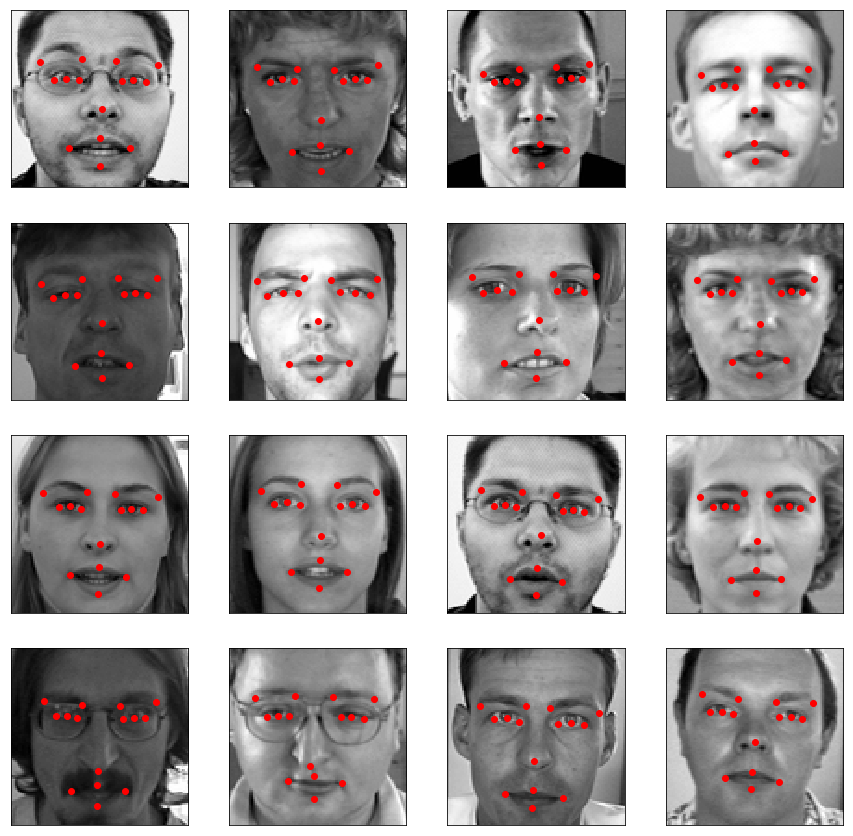

In [49]:
fig = plt.figure(figsize=(15,15))
# 在測試集圖片上用剛剛訓練好的模型做關鍵點的預測
points_test = model.predict(imgs_test.reshape(imgs_test.shape[0], 96, 96, 1))

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_keypoints(imgs_test[i], np.squeeze(points_test[i]))

目前為止，大致可以觀察到，直接使用簡單的模型以及訓練方式在這組數據上應該可以在訓練集和測試集上都得到一個還不錯的結果，說明這組資料其實不會很難。

In [50]:
model_with_augment = get_model()
model_with_augment.compile(loss='mean_squared_error', optimizer='adam')

In [51]:
# Your code
# 實現圖片以及關機點 label 做左右翻轉的函數
def augment_data(img, point):
    rows, cols = img.shape
    new_image = np.copy(img)
    
    # 翻轉照片 (最前面的陣列數值跟最後面的數值交換)
    for i in range(96):
        for j in range(48):
            temp = img[i][j]
            new_image[i][j] = img[i][cols - j - 1]
            new_image[i][cols -j - 1] = temp
    
    # 翻轉關鍵點 label(把X軸家負號)
    new_points = np.copy(point)
    for i in range(0, 30, 2):
        new_points[i] = -point[i]
    
    # 調整對稱的 label 
    return new_image, new_points

def augment_data2(img, point):
    rows, cols = img.shape
    new_image = np.copy(img)
    
    # 翻轉照片 (最前面的陣列數值跟最後面的數值交換)
    for i in range(96):
        for j in range(48):
            temp = img[i][j]
            new_image[i][j] = img[i][cols - j - 1]
            new_image[i][cols -j - 1] = temp
    
    # 翻轉關鍵點 label(把X軸家負號)
    new_points = np.copy(point)
    for i in range(0, 30, 2):
        new_points[i] = -point[i]
    
    new_points_temp = np.copy(new_points)
    new_points[0:2] = new_points_temp[2:4]
    new_points[2:4] = new_points_temp[0:2]
    new_points[4:6] = new_points_temp[8:10]
    new_points[6:8] = new_points_temp[10:12]
    new_points[8:10] = new_points_temp[4:6]
    new_points[10:12] = new_points_temp[6:8]
    new_points[12:14] = new_points_temp[16:18]
    new_points[14:16] = new_points_temp[18:20]
    new_points[16:18] = new_points_temp[12:14]
    new_points[18:20] = new_points_temp[14:16]
    new_points[22:24] = new_points_temp[24:26]
    new_points[24:26] = new_points_temp[22:24]
    
    # 調整對稱的 label 
    return new_image, new_points

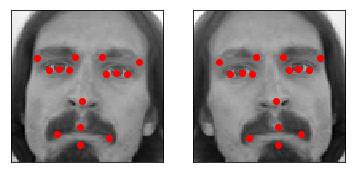

In [52]:
flip_img, flip_points = augment_data(imgs_train[0], points_train[0])

fig = plt.figure()
ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
plot_keypoints(imgs_train[0], points_train[0]) # 原來的圖片
ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
plot_keypoints(flip_img, flip_points) # 翻轉後的圖片

In [53]:
aug_imgs_train = []
aug_points_train = []

# 對所有原始資料做 augmentation
for i in range(imgs_train.shape[0]):
    aug_img, aug_point = augment_data(imgs_train[i], points_train[i])
    
    # 加入原始資料
    aug_imgs_train.append(imgs_train[i])
    aug_points_train.append(points_train[i])

    # 加入翻轉後的資料
    aug_imgs_train.append(aug_img)
    aug_points_train.append(aug_point)
    
# convert to numpy
aug_imgs_train = np.array(aug_imgs_train)   
aug_points_train = np.copy(aug_points_train)

print(aug_imgs_train.shape)
print(aug_points_train.shape)

(4280, 96, 96)
(4280, 30)


In [59]:
best_weights_augment_path = "D:\\Python\\1st DL\\Day044\\best_weights_augment.h5"
file_augment_path = "D:\\Python\\1st DL\\Day044\\file_augment.json"
weights_augment_path = "D:\\Python\\1st DL\\Day044\\weights_augment.h5"
model_augment_path = "D:\\Python\\1st DL\\Day044\\model_augment.h5"

# model checkpoint 
checkpoint = ModelCheckpoint(best_weights_path, verbose=1, save_best_only=True)
hist = History()

model, hist_model = model_fit(model_with_augment, file_augment_path, weights_augment_path, model_augment_path, checkpoint)

Train on 1712 samples, validate on 428 samples
Epoch 1/150
1712/1712 [==============================] - 8s 5ms/step - loss: 0.0074 - val_loss: 0.0022

Epoch 00001: val_loss improved from inf to 0.00225, saving model to D:\Python\1st DL\Day044\best_weights.h5
Epoch 2/150
1712/1712 [==============================] - 7s 4ms/step - loss: 0.0018 - val_loss: 0.0020

Epoch 00002: val_loss improved from 0.00225 to 0.00197, saving model to D:\Python\1st DL\Day044\best_weights.h5
Epoch 3/150
1712/1712 [==============================] - 7s 4ms/step - loss: 0.0014 - val_loss: 0.0021

Epoch 00003: val_loss did not improve from 0.00197
Epoch 4/150
1712/1712 [==============================] - 7s 4ms/step - loss: 0.0013 - val_loss: 0.0019

Epoch 00004: val_loss improved from 0.00197 to 0.00186, saving model to D:\Python\1st DL\Day044\best_weights.h5
Epoch 5/150
1712/1712 [==============================] - 7s 4ms/step - loss: 0.0011 - val_loss: 0.0019

Epoch 00005: val_loss did not improve from 0.00186

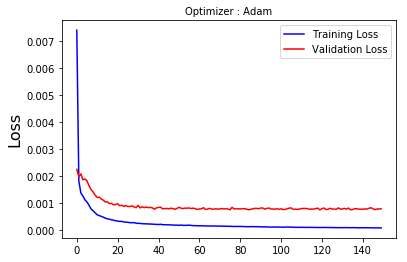

In [60]:
# loss 值的圖
plt.title('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist_model['loss'], color='b', label='Training Loss')
plt.plot(hist_model['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')


### 觀察 model 在 testing 上的結果

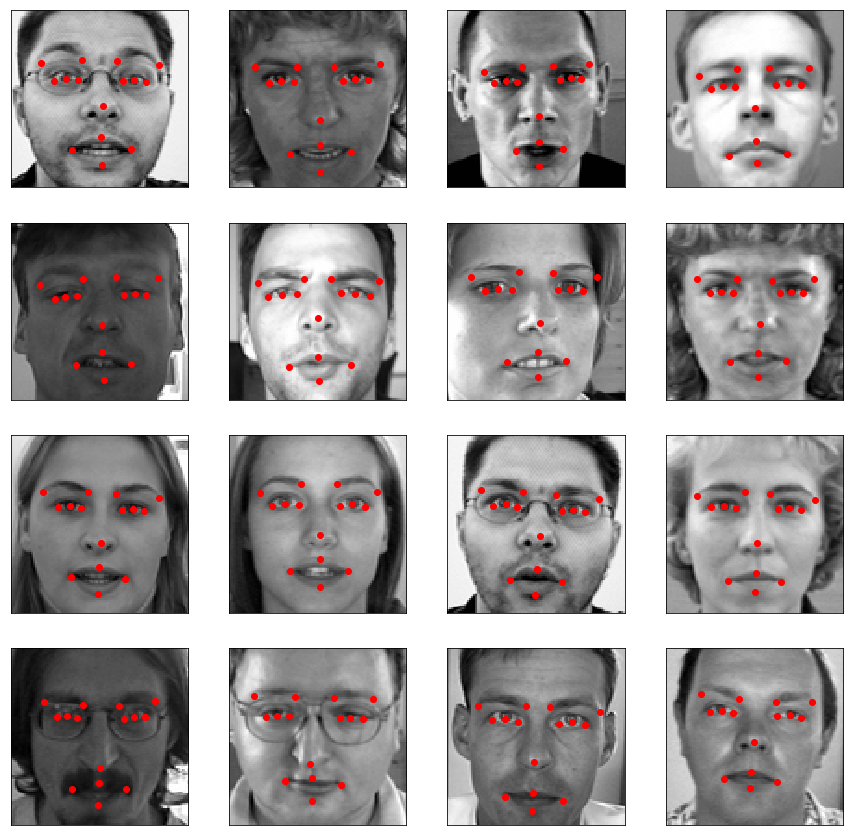

In [62]:
fig = plt.figure(figsize=(15,15))
# 在測試集圖片上用剛剛訓練好的模型做關鍵點的預測
points_test = model.predict(imgs_test.reshape(imgs_test.shape[0], 96, 96, 1))

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_keypoints(imgs_test[i], np.squeeze(points_test[i]))

